# 01. Data Preparation and Exploration

This notebook is used to prepare the chest X-ray lung segmentation dataset. It includes:

- Scanning the existing `image` and `mask` folders  
- Generating `metadata.csv` and `split.csv`  
- Dataset statistics and visualization  
- Verifying data integrity


In [3]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import our modules
from data.prepare_data import prepare_dataset, load_config

# Configure plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


## 1. Load Configuration and Check Data Paths

In [9]:
# Load configuration
config = load_config('../configs/default.yaml')

print("Configuration Info:")
print(f"Image Directory: {config['data']['image_dir']}")
print(f"Mask Directory: {config['data']['mask_dir']}")
print(f"Image Size: {config['dataset']['image_size']}")
print(f"Data Split Ratio: train={config['split']['train']}, val={config['split']['val']}, test={config['split']['test']}")

# Check if paths exist
image_dir = Path(config['data']['image_dir'])
mask_dir = Path(config['data']['mask_dir'])

print(f"\nPath Check:")
print(f"Image directory exists: {image_dir.exists()}")
print(f"Mask directory exists: {mask_dir.exists()}")

if image_dir.exists():
    image_files = list(image_dir.glob('*'))
    print(f"Number of image files: {len(image_files)}")
    
if mask_dir.exists():
    mask_files = list(mask_dir.glob('*'))
    print(f"Number of mask files: {len(mask_files)}")


配置信息:
图片目录: /Users/t/Documents/DISSERTATION/Chest-X-Ray/image
Mask目录: /Users/t/Documents/DISSERTATION/Chest-X-Ray/mask
图片尺寸: [512, 512]
数据划分比例: train=0.7, val=0.15, test=0.15

路径检查:
图片目录存在: True
Mask目录存在: True
图片文件数量: 704
Mask文件数量: 704


## 2. Prepare the Dataset

In [11]:
# Run data preparation
metadata_df, split_df = prepare_dataset(
    image_dir=config['data']['image_dir'],
    mask_dir=config['data']['mask_dir'],
    output_dir='../data',
    test_size=config['split']['test'] + config['split']['val'],
    val_size=config['split']['val'] / (config['split']['test'] + config['split']['val']),
    random_seed=config['split']['random_seed']
)

print(f"Metadata shape: {metadata_df.shape}")
print(f"Split info shape: {split_df.shape}")


正在准备数据集...
Scanning data folders...
Found 704 image files
Found 704 mask files
Found 704 paired image-mask files
Validating image-mask pairs...


Validating: 100%|█████████████████████████████| 704/704 [00:14<00:00, 47.04it/s]

Valid pairs: 704

Dataset Statistics:
Total samples: 704
Average positive ratio: 0.253
Image size range: 1225x989 to 4892x4892
Metadata saved to ../data/metadata.csv

Splitting dataset...
Dataset split:
  Train: 246 samples (34.9%)
  Val: 246 samples (34.9%)
  Test: 212 samples (30.1%)
Split info saved to ../data/split.csv

数据准备完成!
元数据shape: (704, 8)
划分信息shape: (704, 2)


## 3. Data Statistics and Analysis

In [13]:
# Basic statistical information
print("=== Basic Dataset Information ===")
print(f"Total samples: {len(metadata_df)}")
print(f"Image size range:")
print(f"  Width: {metadata_df['width'].min()} - {metadata_df['width'].max()}")
print(f"  Height: {metadata_df['height'].min()} - {metadata_df['height'].max()}")
print(f"\nPositive sample ratio statistics:")
print(f"  Mean: {metadata_df['positive_ratio'].mean():.4f}")
print(f"  Median: {metadata_df['positive_ratio'].median():.4f}")
print(f"  Standard Deviation: {metadata_df['positive_ratio'].std():.4f}")
print(f"  Minimum: {metadata_df['positive_ratio'].min():.4f}")
print(f"  Maximum: {metadata_df['positive_ratio'].max():.4f}")

# Dataset split statistics
split_counts = split_df['split'].value_counts()
print(f"\n=== Dataset Split Statistics ===")
for split in ['train', 'val', 'test']:
    count = split_counts.get(split, 0)
    ratio = count / len(split_df) * 100
    print(f"{split.upper()}: {count} samples ({ratio:.1f}%)")


=== 数据集基本信息 ===
总样本数: 704
图片尺寸范围:
  宽度: 1225 - 4892
  高度: 989 - 4892

正样本比例统计:
  均值: 0.2532
  中位数: 0.2507
  标准差: 0.0584
  最小值: 0.0835
  最大值: 0.4326

=== 数据划分统计 ===
TRAIN: 246 样本 (34.9%)
VAL: 246 样本 (34.9%)
TEST: 212 样本 (30.1%)


## 4. Data Visualization

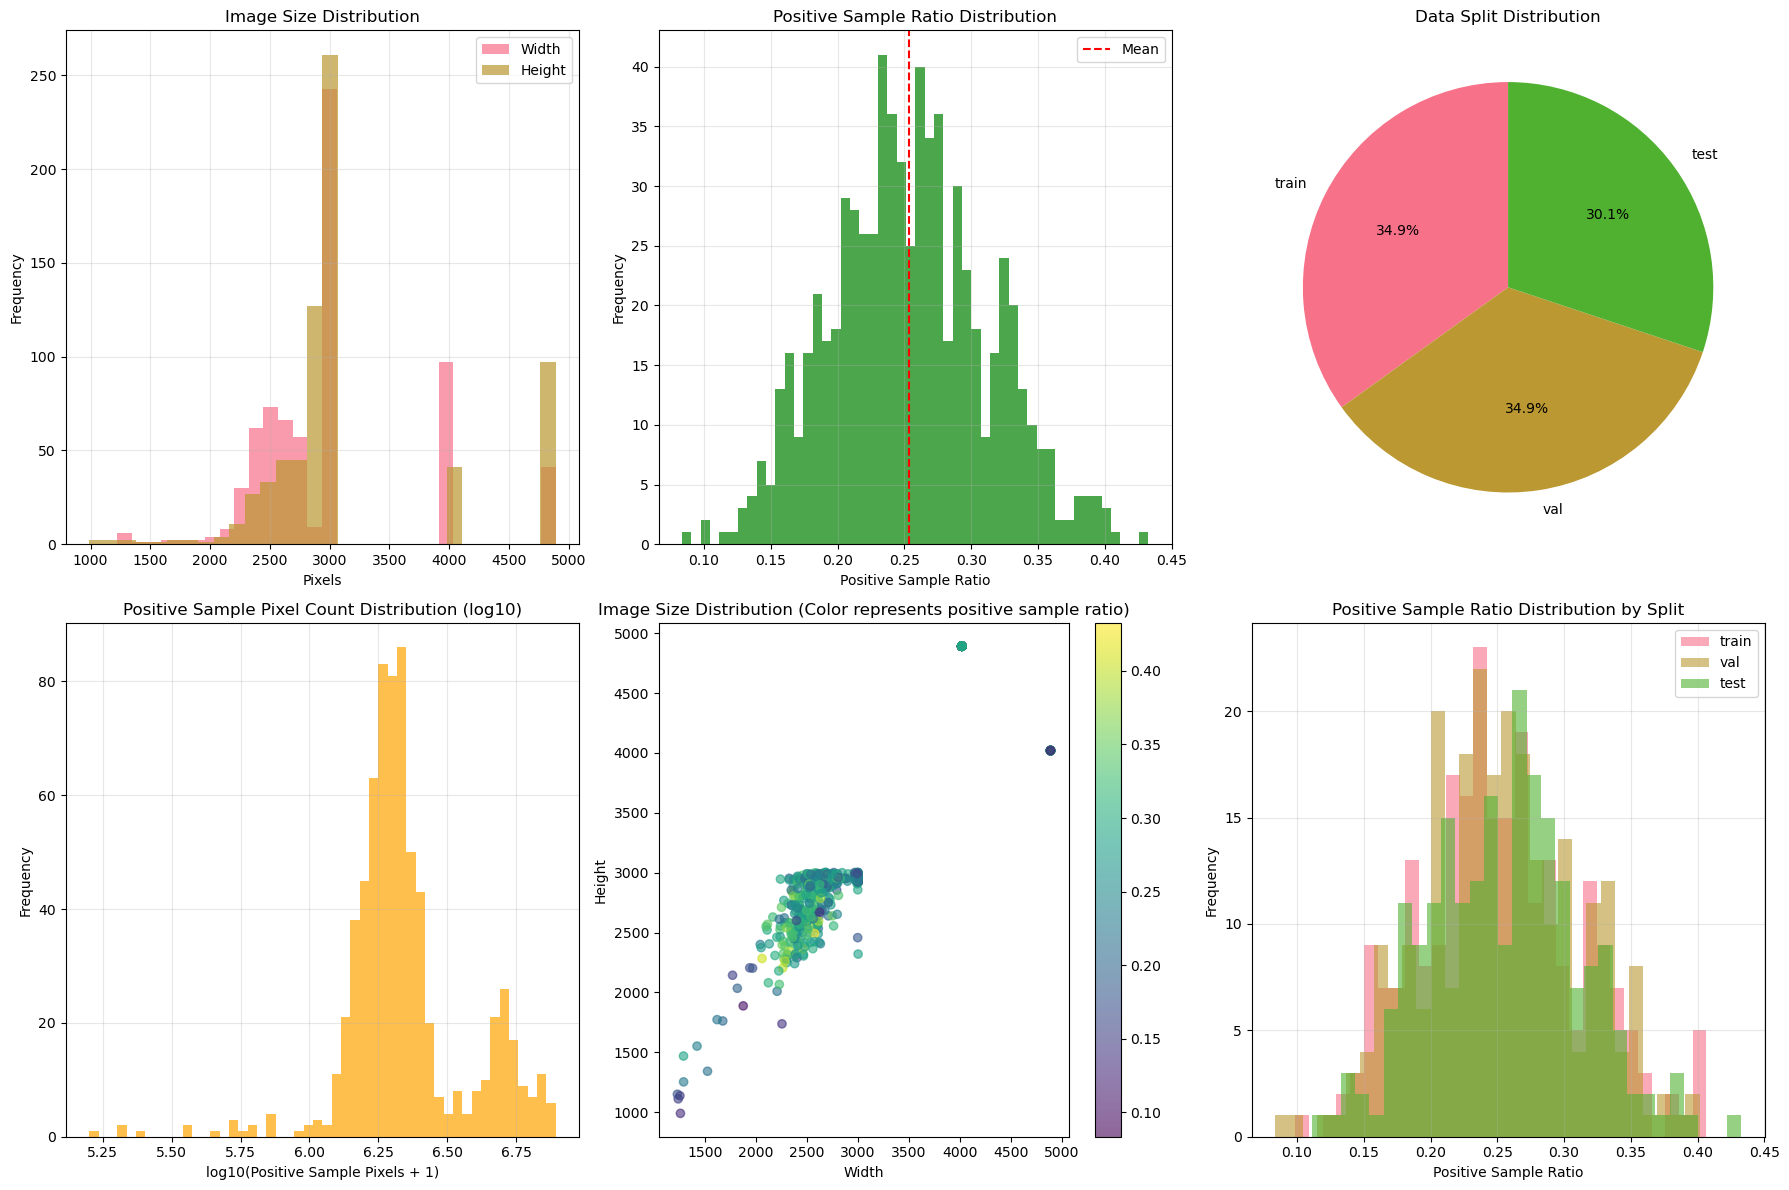

In [17]:
# Create visualization charts
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Image size distribution
axes[0, 0].hist(metadata_df['width'], bins=30, alpha=0.7, label='Width')
axes[0, 0].hist(metadata_df['height'], bins=30, alpha=0.7, label='Height')
axes[0, 0].set_title('Image Size Distribution')
axes[0, 0].set_xlabel('Pixels')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Positive sample ratio distribution
axes[0, 1].hist(metadata_df['positive_ratio'], bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('Positive Sample Ratio Distribution')
axes[0, 1].set_xlabel('Positive Sample Ratio')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(metadata_df['positive_ratio'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Data split pie chart
split_counts = split_df['split'].value_counts()
axes[0, 2].pie(split_counts.values, labels=split_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Data Split Distribution')

# 4. Positive sample pixel count distribution
axes[1, 0].hist(np.log10(metadata_df['positive_pixels'] + 1), bins=50, alpha=0.7, color='orange')
axes[1, 0].set_title('Positive Sample Pixel Count Distribution (log10)')
axes[1, 0].set_xlabel('log10(Positive Sample Pixels + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 5. Image size scatter plot
scatter = axes[1, 1].scatter(metadata_df['width'], metadata_df['height'], 
                           c=metadata_df['positive_ratio'], cmap='viridis', alpha=0.6)
axes[1, 1].set_title('Image Size Distribution (Color represents positive sample ratio)')
axes[1, 1].set_xlabel('Width')
axes[1, 1].set_ylabel('Height')
plt.colorbar(scatter, ax=axes[1, 1])

# 6. Positive sample ratio distribution by split
for split in ['train', 'val', 'test']:
    split_names = split_df[split_df['split'] == split]['image_name']
    split_data = metadata_df[metadata_df['image_name'].isin(split_names)]
    axes[1, 2].hist(split_data['positive_ratio'], bins=30, alpha=0.6, label=split)

axes[1, 2].set_title('Positive Sample Ratio Distribution by Split')
axes[1, 2].set_xlabel('Positive Sample Ratio')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Data Sample Visualization

随机样本可视化:


/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31572/3913583631.py:39: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31572/3913583631.py:39: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31572/3913583631.py:39: UserWarning: Glyph 21472 (\N{CJK UNIFIED IDEOGRAPH-53E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6n/2rqv_pbj5r5g_dc4brtwrg800000gn/T/ipykernel_31572/3913583631.py:39: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/a

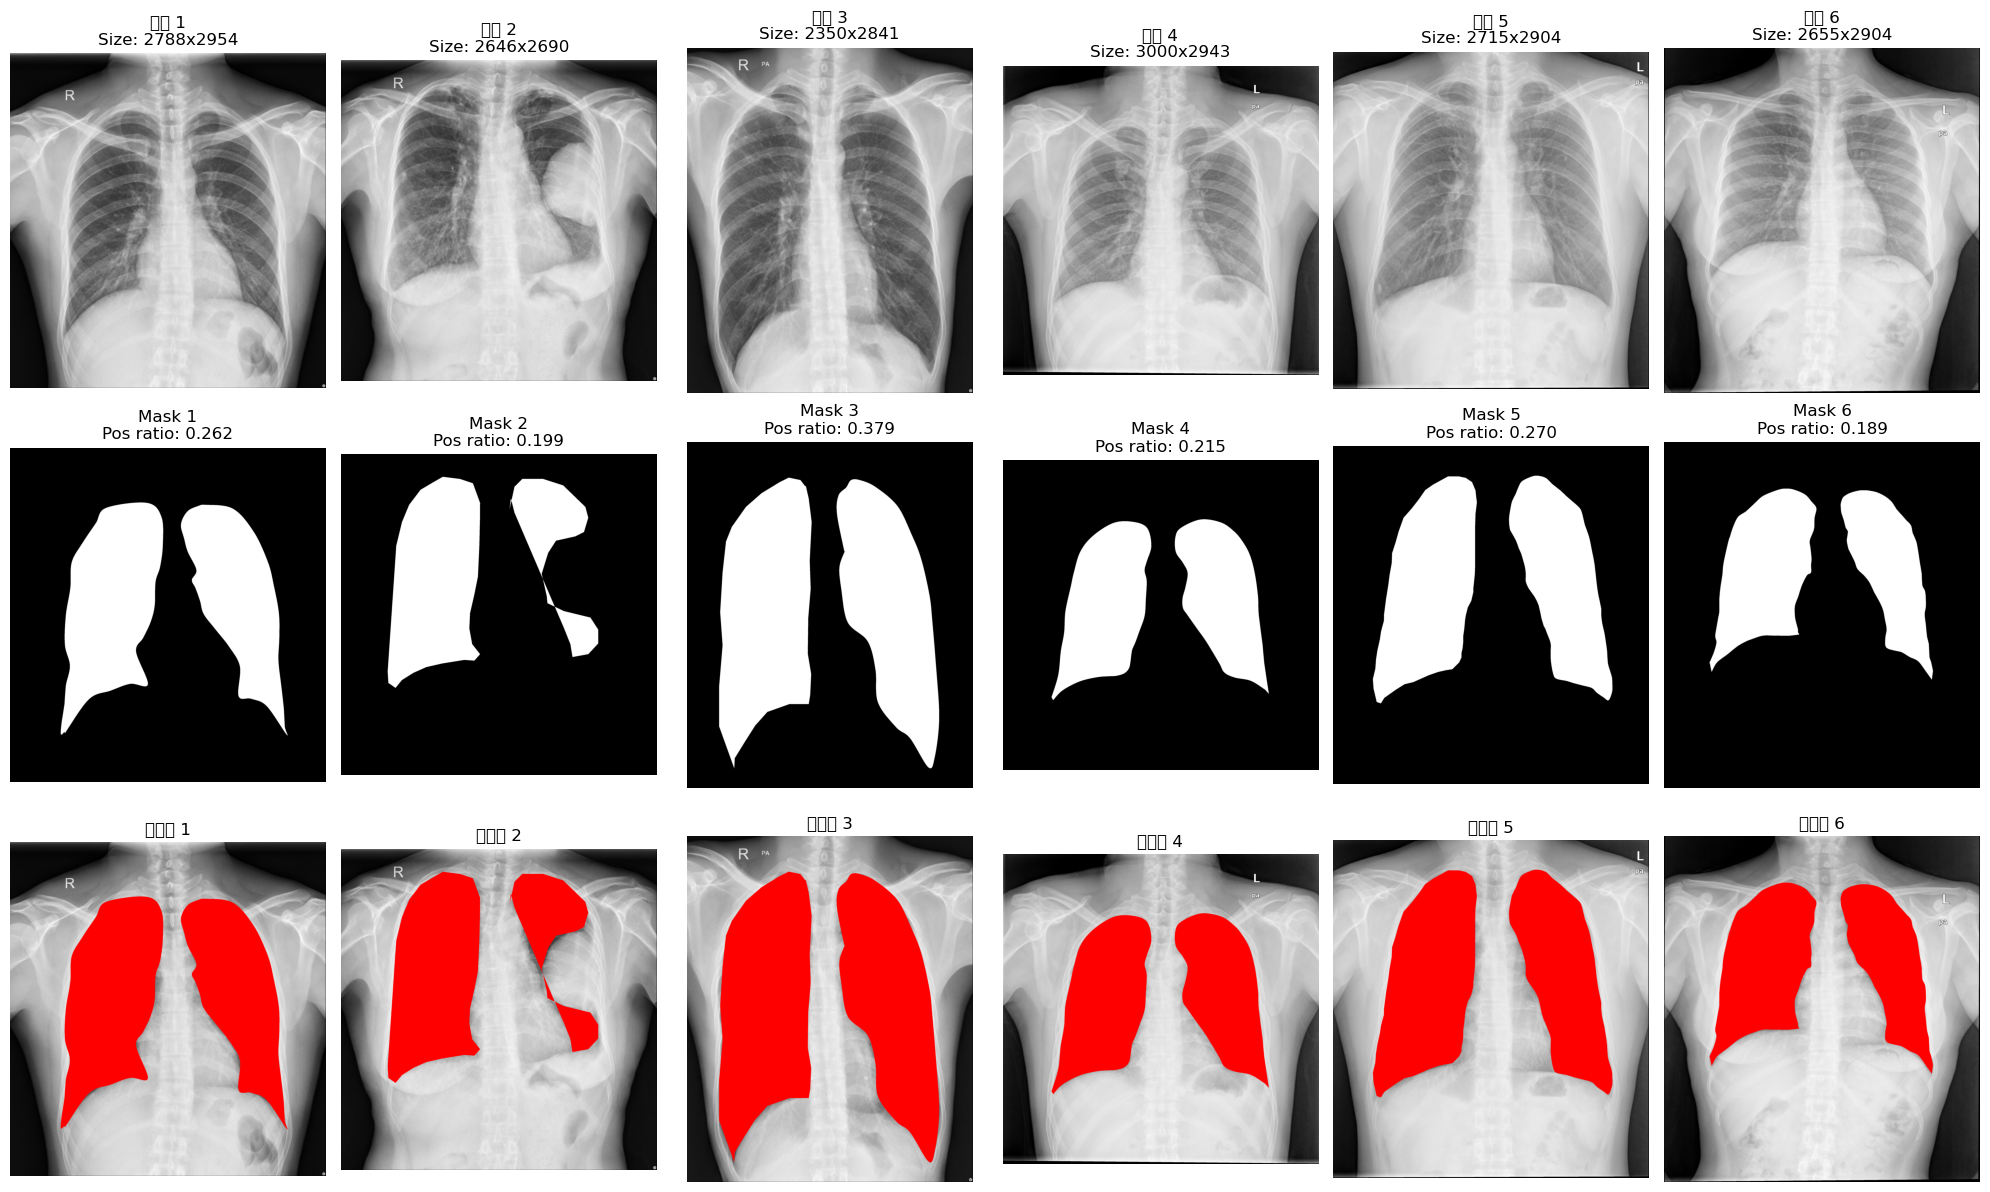

In [11]:
# Visualize some samples
from PIL import Image
import cv2

def visualize_samples(metadata_df, num_samples=6):
    """Visualize data samples."""
    # Randomly select samples
    sample_indices = np.random.choice(len(metadata_df), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    
    for i, idx in enumerate(sample_indices):
        row = metadata_df.iloc[idx]
        
        # Load image and mask
        image = np.array(Image.open(row['image_path']).convert('L'))
        mask = np.array(Image.open(row['mask_path']).convert('L'))
        mask = (mask > 127).astype(np.uint8) * 255
        
        # Create overlay
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        overlay[mask > 0] = [255, 0, 0]  # Show mask regions in red
        
        # Show original image
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f'Original {i+1}\nSize: {row["width"]}x{row["height"]}')
        axes[0, i].axis('off')
        
        # Show mask
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'Mask {i+1}\nPos ratio: {row["positive_ratio"]:.3f}')
        axes[1, i].axis('off')
        
        # Show overlay
        axes[2, i].imshow(overlay)
        axes[2, i].set_title(f'Overlay {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
print("Random sample visualization:")
visualize_samples(metadata_df, num_samples=6)


## 6. Data Quality Check

In [13]:
# Check for anomalous data
# Check for empty masks
empty_masks = metadata_df[metadata_df['positive_pixels'] == 0]
print(f"Number of empty masks: {len(empty_masks)} ({len(empty_masks)/len(metadata_df)*100:.1f}%)")

# Check images with abnormal sizes
size_threshold = 2000  # pixels
large_images = metadata_df[(metadata_df['width'] > size_threshold) | (metadata_df['height'] > size_threshold)]
print(f"Number of abnormally large images (>{size_threshold}px): {len(large_images)}")

small_images = metadata_df[(metadata_df['width'] < 256) | (metadata_df['height'] < 256)]
print(f"Number of abnormally small images (<256px): {len(small_images)}")

# Check for abnormal positive sample ratios
high_ratio = metadata_df[metadata_df['positive_ratio'] > 0.5]
low_ratio = metadata_df[metadata_df['positive_ratio'] < 0.01]
print(f"Positive ratio too high (>50%): {len(high_ratio)}")
print(f"Positive ratio too low (<1%): {len(low_ratio)}")

# Check for duplicate filenames
duplicate_names = metadata_df[metadata_df['image_name'].duplicated()]
print(f"Duplicate filenames: {len(duplicate_names)}")



=== 数据质量检查 ===
空mask数量: 0 (0.0%)
异常大图片数量 (>2000px): 693
异常小图片数量 (<256px): 0
正样本比例过高 (>50%): 0
正样本比例过低 (<1%): 0
重复文件名: 0

=== 数据完整性检查通过! ===


## 7. Saving Processing Results

In [15]:
# Save statistical report
report = {
    'dataset_summary': {
        'total_samples': len(metadata_df),
        'train_samples': len(split_df[split_df['split'] == 'train']),
        'val_samples': len(split_df[split_df['split'] == 'val']),
        'test_samples': len(split_df[split_df['split'] == 'test']),
        'avg_positive_ratio': float(metadata_df['positive_ratio'].mean()),
        'avg_image_size': {
            'width': int(metadata_df['width'].mean()),
            'height': int(metadata_df['height'].mean())
        }
    },
    'quality_checks': {
        'empty_masks': len(empty_masks),
        'large_images': len(large_images),
        'small_images': len(small_images),
        'duplicate_names': len(duplicate_names)
    }
}

import json
os.makedirs('../outputs', exist_ok=True)
with open('../outputs/data_preparation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("Data preparation report has been saved to outputs/data_preparation_report.json")


数据准备报告已保存到 outputs/data_preparation_report.json

=== 数据准备阶段完成! ===

下一步: 运行 02_unet_training.ipynb 开始U-Net模型训练


In [41]:
%cd ~/Documents/DISSERTATION


/Users/t/Documents/DISSERTATION
